In [1]:
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
from pathlib import Path
import h5py

# 1) block 'blood-oxygen' 
cur = Path.cwd()
bo_root = next(p for p in [cur, *cur.parents] if p.name == "blood-oxygen")

# 2) into spo2-phonecam (subsystem of author)
spo2_root = bo_root / "spo2-phonecam"

# 3) (form the pathway of data.h5)
H5 = (spo2_root / "external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5").resolve()
print("Using:", H5)
assert H5.exists(), f"not exist：{H5}"

# 4) read
with h5py.File(H5, "r") as f:
    print("Keys:", list(f.keys()))
    data = f["dataset"][:]
    gt   = f["groundtruth"][:]
print(data.shape, gt.shape)


Using: /Users/katyhuang/Desktop/blood-oxygen/spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5
Keys: ['dataset', 'groundtruth']
(6, 6, 33660) (6, 5, 1122)


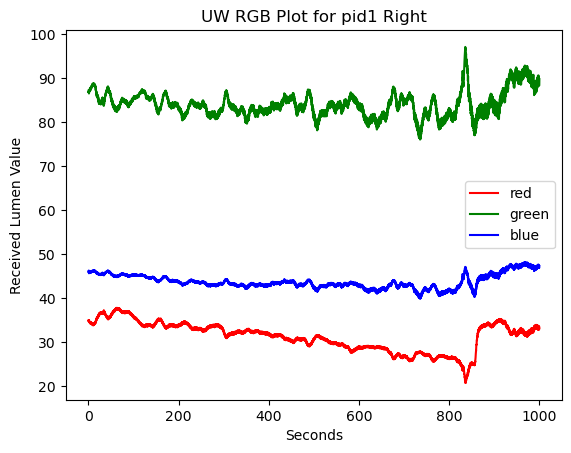

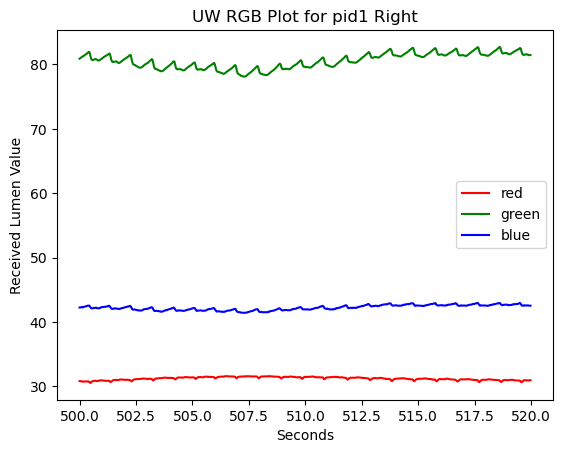

In [6]:
# Plot the red, green, and blue chanel in the time range. Choose either left or right hand.
def plot_RGB(data, pid=0, left=True, sec_from=0, sec_to=1000):
    title = "pid" + str(pid+1)
    X = np.arange(sec_from, sec_to, 1/30)
    if left:
        plt.plot(X, data[pid, 0, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 1, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 2, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Left"
    else:
        plt.plot(X, data[pid, 3, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 4, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 5, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Right"
    plt.title("UW RGB Plot for " + title)
    plt.legend()
    plt.xlabel("Seconds")
#     plt.ylim(0, 250)
    plt.ylabel("Received Lumen Value")
    plt.show()
    
plot_RGB(data, pid=0, left=False, sec_from=0, sec_to=1000)
plot_RGB(data, pid=0, left=False, sec_from=500, sec_to=520)

In [7]:
# Make a list of data points for visualizing or training
def make_temp_data(data_uw, groundtruth_uw, data_idx=[], gt_ind = 3):
    # Select 0th sample, right hand
    res_data_list = []
    res_gt_list = []
    for pid, row in enumerate(data_idx):
        if row[0] == 1:
            res_data_list.append(data_uw[pid][:3,:])
            res_gt_list.append(groundtruth_uw[pid][gt_ind,:])
        if row[1] == 1:
            res_data_list.append(data_uw[pid][3:,:]) 
            res_gt_list.append(groundtruth_uw[pid][gt_ind, :])

    results_data_list = []
    results_gt_list = []
    fps_list = []
    for i in range(len(res_gt_list)):
        # find zeros
        zeros_data = np.where(res_data_list[i][0] == 0)[0]
        zeros_gt = np.where(res_gt_list[i] == 0)[0]

        if len(zeros_data) > 0:
            result_data_i = res_data_list[i][:, :int(zeros_data[0])]
        else:
            result_data_i = res_data_list[i]
        if len(zeros_gt) > 0:
            result_gt_i = res_gt_list[i][:int(zeros_gt[0])]
        else:
            result_gt_i = res_gt_list[i]

        # Calculate shorter and clip
        fps = 30
        clip_len = min(result_gt_i.shape[0], result_data_i.shape[1] // fps)
        result_data_i = result_data_i[:, :clip_len*fps]
        result_gt_i = result_gt_i[:clip_len]

        results_gt_list.append(result_gt_i)
        results_data_list.append(result_data_i)
        fps_list.append(fps)

    return {"data": results_data_list, "gt": results_gt_list, "fps": fps_list}

UW: mean=87.220673, std=9.325543


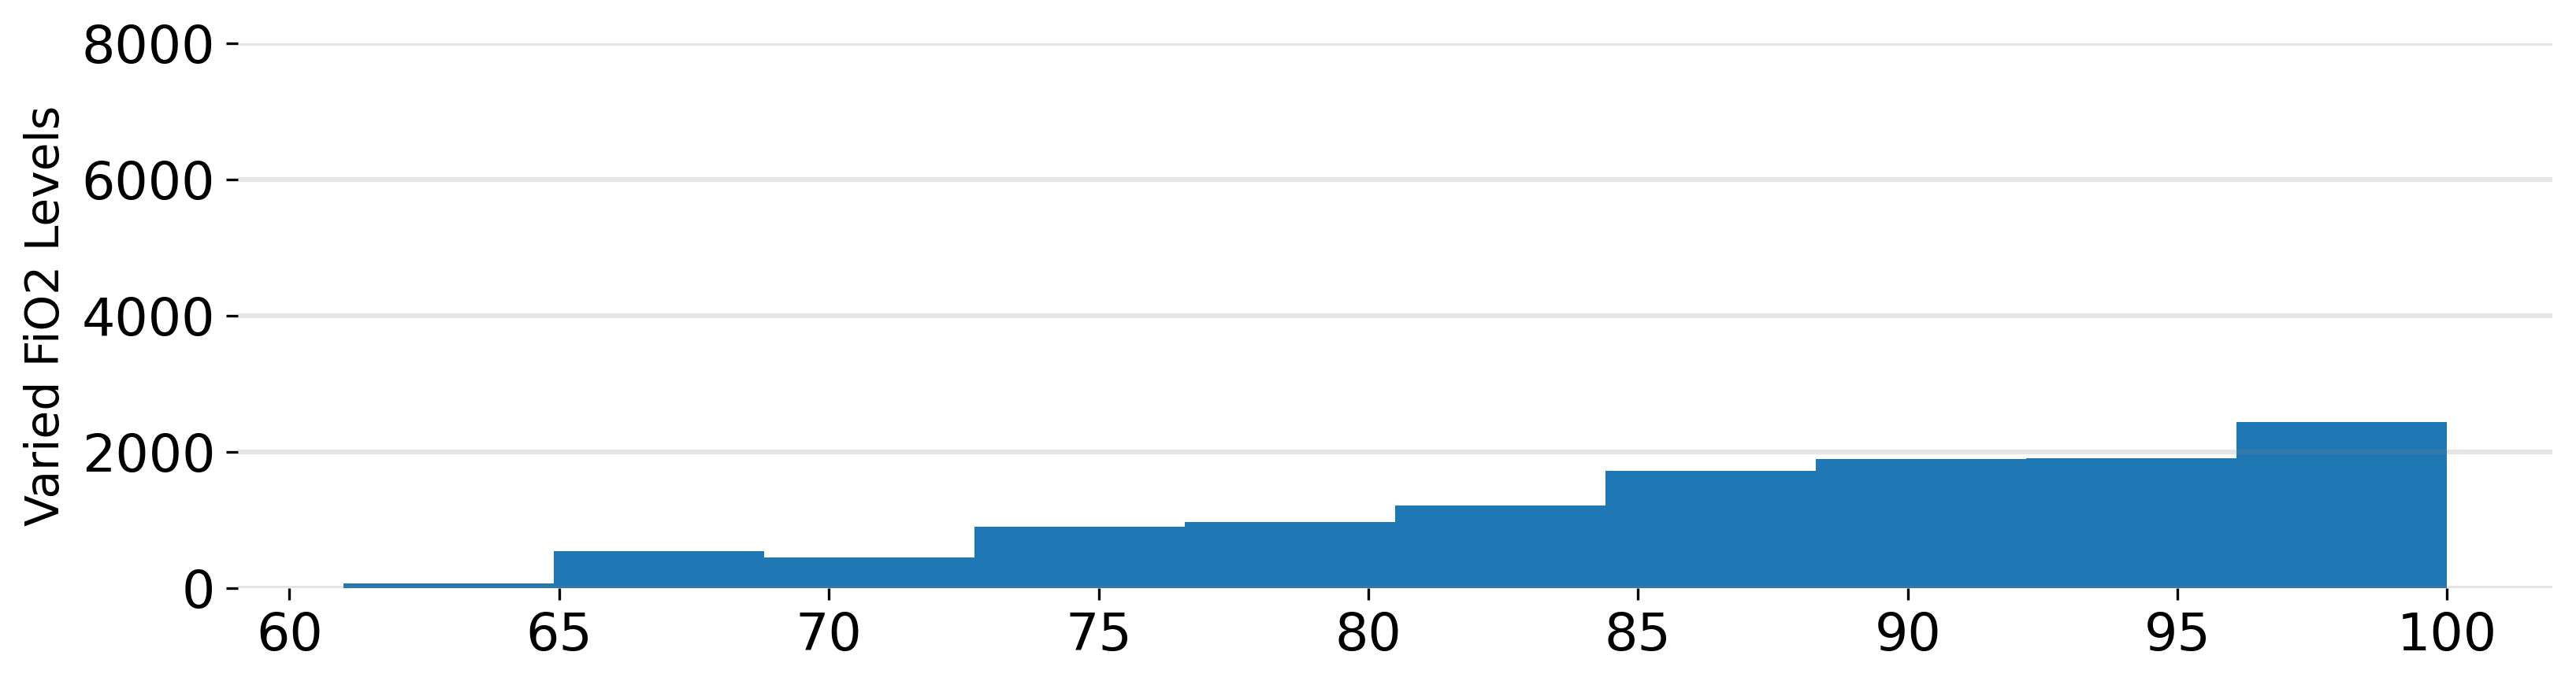

In [5]:
# Plot a historgram of the data distribution
def hist_UW():
    all_data_idx = np.ones((6,2))
    all_seq = make_temp_data(data, groundtruth, gt_ind=3, data_idx=all_data_idx)
    gtdatapoints = []
    for seq in all_seq["gt"]:
        gtdatapoints.extend(seq)
    gtdatapoints = np.array(gtdatapoints)
    print('UW: mean=%f, std=%f' % \
          (np.mean(gtdatapoints),np.std(gtdatapoints)))
    plt.figure(figsize=(11,3),dpi=300)
    plt.hist(gtdatapoints,bins=10, )
    ax = plt.gca()

    ax.set_ylim(top=8000)

    locs = ax.yaxis.get_ticklocs()
    labs = ax.yaxis.get_ticklabels()
    # print([lab.get_text() for lab in ax.yaxis.get_ticklabels()])
    new_locs = []
    new_labs = []
    for i, (loc, lab) in enumerate(list(zip(locs, labs))):
        if (i) % 2 == 0:
            # if i == 0:
            #     continue
            new_locs.append(loc)
            new_labs.append(lab)
            plt.axhline(y=loc, color="grey", alpha=0.2)

    ax.set_yticks(new_locs)
    ax.set_yticklabels(["0", "2000", "4000", "6000", "8000"], fontsize=16)

    # ax.set_xticks(ax.get_xticks(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylabel("Varied FiO2 Levels", fontsize=14)
    plt.tight_layout()

hist_UW()

In [12]:
import os
print(os.path.exists(f'{PATH}/../gt/metadata.csv'))   # True 才是对的


False


In [13]:

#location of the author folder 
PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串

def load_metadata(metapath):
    import pandas as pd
    return pd.read_csv(metapath)

# View metadata descriptions
meta_df = load_metadata(metapath=f'{PATH}/../gt/metadata.csv')
print(meta_df.shape)


(44, 3)


In [14]:
# View metadata descriptions
def load_metadata(metapath):
    meta_df = pd.read_csv(metapath)
#     print()
    return meta_df

load_metadata(metapath=f'{PATH}//..//gt/metadata.csv')

,Label,Description,Unit
0,SpO2 1,SpO2 reading from PPG of pulse ox 1 (3900P TT+...,Percentage
1,SpO2 2,SpO2 reading from PPG of pulse ox 2 (Nellcor N...,Percentage
2,SpO2 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
3,SpO2 4,SpO2 reading from PPG of pulse ox 4 (Nellcor N...,Percentage
4,SpO2 5,SpO2 reading from PPG of pulse ox 5 (Masimo Ra...,Percentage
5,Pulse 1,Heart rate from PPG of pulse ox 1 (3900P TT+ 9...,bpm
6,Pulse 2,Heart rate from PPG of pulse ox 2 (Nellcor N-6...,bpm
7,Pulse 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
8,Pulse 4,Heart rate from PPG of pulse ox 4 (Nellcor N-6...,bpm
9,Pulse 5,Heart rate from PPG of pulse ox 5 (Masimo Radi...,bpm


In [18]:
1.# orginal data for model

# === Step 0: pathway + load H5 + metadata ===
import os, re, h5py, pandas as pd

PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串
H5_PATH   = os.path.join(PATH, 'all_uw_data.h5')
META_PATH = os.path.normpath(os.path.join(PATH, '..', 'gt', 'metadata.csv'))

with h5py.File(H5_PATH, 'r') as f:
    print('H5 keys:', list(f.keys()))
    dataset     = f['dataset'][:]       # (subjects, devices, seconds)
    groundtruth = f['groundtruth'][:]

meta_df = pd.read_csv(META_PATH, encoding='utf-8-sig')

print('dataset', dataset.shape, '| groundtruth', groundtruth.shape)
 

H5 keys: ['dataset', 'groundtruth']
dataset (6, 6, 33660) | groundtruth (6, 5, 1122)


In [19]:


# ==== Step 1: choice（Masimo / Radical-7） ====
import os, re

meta_path = os.path.join(PATH, "..", "gt", "metadata.csv")  # #define path
meta_df = load_metadata(meta_path)

cands = [i for i, c in enumerate(meta_df.columns) if re.search(r"masimo|radical", str(c), re.I)]
DEVICE_IDX = cands[0] if cands else 0
print("groundtruth shape:", groundtruth.shape, "(subjects, devices, seconds)")
print("DEVICE_IDX =", DEVICE_IDX, "=>", meta_df.columns[DEVICE_IDX])


groundtruth shape: (6, 5, 1122) (subjects, devices, seconds)
DEVICE_IDX = 0 => Label


In [20]:
# ==== Step 2: 3-second window quality filtering (discard low mean/low variance) ====
import numpy as np
from scipy import signal
from scipy.signal import medfilt

def make_windows_filtered_v2(data, groundtruth, use_left=True, device_idx=0,
                             fps=30, win=90, band=(0.5, 8.0),
                             mean_frac_thr=0.20,    # mean value of the window should be ≥ 20% of the average value of the entire subject channel
                             per_ch_std_thr=1e-3,   # ertain channel within the window is too small, it is considered invalid
                             order=3, med_k=5):
    """
    data: (subjects, channels=6, frames), channel顺序: [L.R, L.G, L.B, R.R, R.G, R.B]
    groundtruth: (subjects, devices, seconds)
    返回：X (N, C, T), y (N,), owners (N,)
    """
    ch = slice(0,3) if use_left else slice(3,6)
    b, a = signal.butter(order, [band[0]/(fps/2), band[1]/(fps/2)], btype="band")

    # subject channel
    subj_mean = np.stack([np.nanmean(data[i, ch, :], axis=1) for i in range(data.shape[0])])  # (subjects, 3)

    Xs, ys, owners = [], [], []
    n_subj, _, n_frames = data.shape
    n_secs = groundtruth.shape[-1]

    for pid in range(n_subj):
        base_mean = np.maximum(subj_mean[pid], 1e-6)  # 防除零
        for sec in range(1, n_secs-1):  # 留出前后1秒
            c = sec * fps
            s, e = c - win//2, c + win//2
            if s < 0 or e > n_frames:
                continue

            y = float(groundtruth[pid, device_idx, sec])
            if not (70.0 <= y <= 100.0):   # 论文规则：<70 的段不评估
                continue

            x = data[pid, ch, s:e]        # (3, win)
            if x.shape[-1] != win:
                continue

            # Quality filtering: low mean/low variance

            if np.any(x.mean(axis=1) < mean_frac_thr * base_mean) or np.any(x.std(axis=1) < per_ch_std_thr):
                continue

            #  z-score
            xf = np.zeros_like(x, dtype=np.float32)
            for k in range(x.shape[0]):
                tmp = signal.filtfilt(b, a, x[k], method="pad")
                tmp = medfilt(tmp, kernel_size=med_k)
                m, sd = tmp.mean(), tmp.std() + 1e-8
                xf[k] = (tmp - m) / sd

            Xs.append(xf.astype(np.float32)); ys.append(y); owners.append(pid)

    X = np.stack(Xs).astype(np.float32)
    y = np.array(ys, np.float32)
    owners = np.array(owners, int)
    print("[v2] X:", X.shape, "y:", y.shape, "subjects:", np.unique(owners))
    return X, y, owners


In [24]:
# ==== Step 3: Merge the left and right hands into 6 channels (one sample) ====
X_L, y, owners  = make_windows_filtered_v2(data, groundtruth, use_left=True,  device_idx=DEVICE_IDX)
X_R, y2, owners2 = make_windows_filtered_v2(data, groundtruth, use_left=False, device_idx=DEVICE_IDX)

# checking loading data
assert np.array_equal(y, y2), "If different, please check groundtruth/DEVICE_IDX"
assert np.array_equal(owners, owners2), "Owners not same, check the data loading"

# merge: 3+3=6 channel
X6 = np.concatenate([X_L, X_R], axis=1).astype(np.float32)
print("X6:", X6.shape, "y:", y.shape)

# Minor diagnosis: Number of samples per subject
from collections import Counter
print("per-subject counts:", Counter(owners.tolist()))
print("any NaN in y?", np.isnan(y).any())

for pid in sorted(set(owners.tolist())):
    yy = y[owners == pid]
    print(f"pid {pid}: n={len(yy)}  min/median/max = "
          f"{float(yy.min()):.1f}/{float(np.median(yy)):.1f}/{float(yy.max()):.1f}")

for thr in (88, 90, 92):
    cnt = int((y < thr).sum())
    print(f"SpO2 < {thr}%: {cnt}/{len(y)} = {cnt/len(y):.1%}")


[v2] X: (5819, 3, 90) y: (5819,) subjects: [0 1 2 3 4 5]
[v2] X: (5819, 3, 90) y: (5819,) subjects: [0 1 2 3 4 5]
X6: (5819, 6, 90) y: (5819,)
per-subject counts: Counter({1: 1119, 2: 1031, 3: 1013, 0: 972, 4: 892, 5: 792})
any NaN in y? False
pid 0: n=972  min/median/max = 70.0/91.6/99.6
pid 1: n=1119  min/median/max = 70.1/89.0/98.5
pid 2: n=1031  min/median/max = 70.0/91.1/100.0
pid 3: n=1013  min/median/max = 76.8/90.4/99.3
pid 4: n=892  min/median/max = 70.0/88.6/98.2
pid 5: n=792  min/median/max = 70.1/86.9/98.5
SpO2 < 88%: 2388/5819 = 41.0%
SpO2 < 90%: 2974/5819 = 51.1%
SpO2 < 92%: 3472/5819 = 59.7%


In [25]:
# ==== Step 4: model & LOSO training ====
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import mean_absolute_error
import numpy as np

class Shallow1DCNN(nn.Module):
    def __init__(self, in_ch=6):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 32, 7, padding=3), nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, 5, padding=2),    nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64, 1))
    def forward(self, x):  # x: (B, C, T)
        return self.head(self.feat(x)).squeeze(1)

def run_loso_generic(X, y, owners, model_factory,
                     epochs=160, base_lr=3e-4, wd=5e-4, bs=256, patience=25,
                     low_weight=5.0, seed=42):
    device = "cuda" if torch.cuda.is_available() else ("mps" if hasattr(torch.backends,'mps') and torch.backends.mps.is_available() else "cpu")
    print("device:", device)
    rng = np.random.default_rng(seed)

    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float().unsqueeze(1)
    subjects = np.unique(owners)

    y_true_all, y_pred_all, per = [], [], []
    for held in subjects:
        te = np.where(owners == held)[0]
        tr = np.where(owners != held)[0]

        # 10% verification
        rng.shuffle(tr)
        n_val = max(1, int(len(tr) * 0.1))
        va, tr = tr[:n_val], tr[n_val:]

        # Weighted (unbalanced) hypoxic section
        w = torch.ones(len(tr))
        w[(y_t[tr].squeeze(1) < 90).cpu()] = low_weight
        sampler = WeightedRandomSampler(weights=w, num_samples=len(w), replacement=True)

        model = model_factory(X.shape[1]).to(device)
        
        # First, store the initial weights to prevent the loss of best in case of an extremely early stop
        
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        opt = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=wd)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        loss = nn.SmoothL1Loss()

        best_mae, wait = 1e9, patience
        for ep in range(epochs):
            model.train()
            dl = DataLoader(TensorDataset(X_t[tr], y_t[tr]), batch_size=bs, sampler=sampler, drop_last=False)
            for xb, yb in dl:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad(); pred = model(xb); l = loss(pred, yb.squeeze(1)); l.backward(); opt.step()
            sch.step()

            # verification
            model.eval()
            with torch.no_grad():
                dlv = DataLoader(TensorDataset(X_t[va], y_t[va]), batch_size=bs, shuffle=False, drop_last=False)
                pv, gv = [], []
                for xb, yb in dlv:
                    pv.append(model(xb.to(device)).cpu().numpy()); gv.append(yb.numpy())
                pv = np.concatenate(pv).squeeze(); gv = np.concatenate(gv).squeeze()
                mae_va = float(mean_absolute_error(gv, pv))

            if mae_va < best_mae - 1e-4:
                best_mae = mae_va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = patience
            else:
                wait -= 1
                if wait <= 0:
                    break

        # test
        model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            dlt = DataLoader(TensorDataset(X_t[te], y_t[te]), batch_size=bs, shuffle=False, drop_last=False)
            pt = [model(xb.to(device)).cpu().numpy() for xb, _ in dlt]
        pt = np.concatenate(pt).squeeze()
        gt = y_t[te].numpy().squeeze()

        fold_mae = float(mean_absolute_error(gt, pt))
        print(f"[LOSO] held={int(held)}  test MAE={fold_mae:.3f}%  n={len(te)}")
        y_true_all.append(gt); y_pred_all.append(pt); per.append({"subject": int(held), "mae": fold_mae, "n": int(len(te))})

    return np.concatenate(y_true_all), np.concatenate(y_pred_all), per

# start testing
y_true6, y_pred6, per6 = run_loso_generic(
    X6, y, owners,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=160, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=5.0
)
print("LOSO mean MAE =", np.mean([r['mae'] for r in per6]))


device: mps
[LOSO] held=0  test MAE=25.215%  n=972
[LOSO] held=1  test MAE=9.333%  n=1119
[LOSO] held=2  test MAE=8.175%  n=1031
[LOSO] held=3  test MAE=4.687%  n=1013
[LOSO] held=4  test MAE=6.636%  n=892
[LOSO] held=5  test MAE=6.278%  n=792
LOSO mean MAE = 10.0540562470754


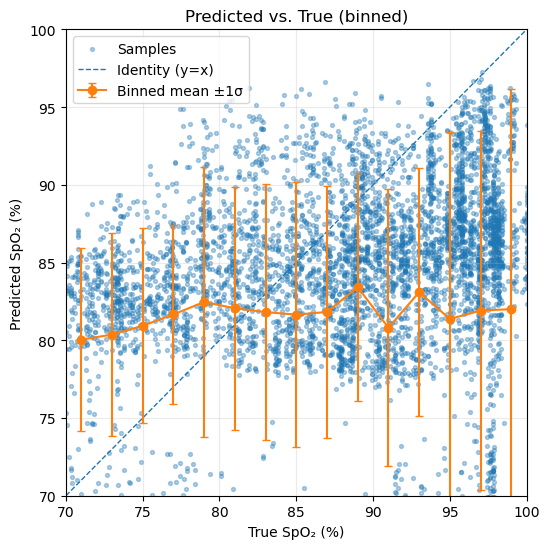

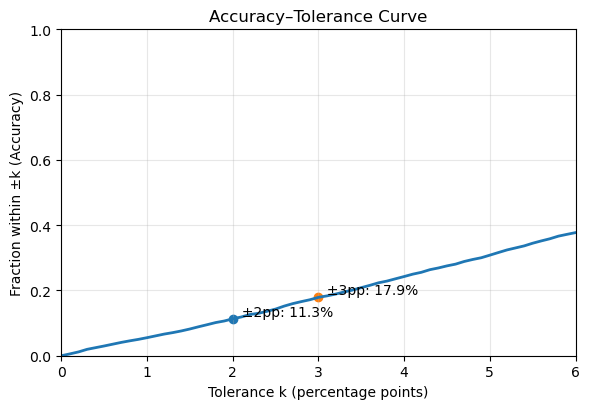

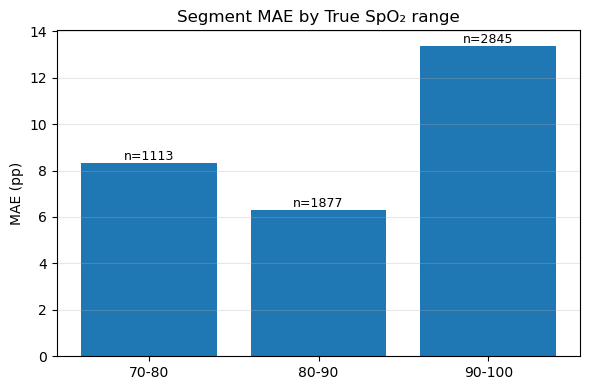

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def spo2_eval_plots(y_true, y_pred, bin_width=2.0, tol_max=6.0, tol_marks=(2.0, 3.0)):
    # ---- 0) to numpy & drop NaN/Inf ----
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[m], y_pred[m]

    # ---- 1) Pred vs True with binned mean ±1σ ----
    lo, hi = 70.0, 100.0
    bins = np.arange(lo, hi + bin_width, bin_width)
    idx = np.digitize(y_true, bins) - 1

    bc, mean_true, mean_pred, err_std = [], [], [], []
    for b in range(len(bins)-1):
        sel = (idx == b)
        if not np.any(sel): 
            continue
        ytb, ypb = y_true[sel], y_pred[sel]
        bc.append((bins[b] + bins[b+1]) / 2)
        mean_true.append(ytb.mean())
        mean_pred.append(ypb.mean())
        err_std.append((ypb - ytb).std())

    plt.figure(figsize=(5.6,5.6))
    plt.scatter(y_true, y_pred, s=8, alpha=0.35, label='Samples')
    x = np.linspace(70, 100, 200)
    plt.plot(x, x, '--', lw=1, label='Identity (y=x)')
    if bc:
        plt.errorbar(bc, mean_pred, yerr=err_std, fmt='o-', capsize=3, label='Binned mean ±1σ')
    plt.xlim(70, 100); plt.ylim(70, 100)
    plt.xlabel('True SpO₂ (%)'); plt.ylabel('Predicted SpO₂ (%)')
    plt.title('Predicted vs. True (binned)')
    plt.legend(loc='upper left'); plt.grid(alpha=0.25); plt.tight_layout()
    plt.show()

    # ---- 2) Accuracy–Tolerance curve: P(|err| ≤ k) ----
    err = np.abs(y_pred - y_true)
    ks = np.arange(0.0, tol_max + 1e-9, 0.1)
    acc = np.array([(err <= k).mean() for k in ks])

    plt.figure(figsize=(6.0,4.2))
    plt.plot(ks, acc, lw=2)
    for mk in tol_marks:
        v = (err <= mk).mean()
        plt.scatter([mk], [v])
        plt.text(mk, v, f'  ±{mk:.0f}pp: {100*v:.1f}%', va='bottom')
    plt.xlabel('Tolerance k (percentage points)')
    plt.ylabel('Fraction within ±k (Accuracy)')
    plt.title('Accuracy–Tolerance Curve')
    plt.ylim(0,1); plt.xlim(0,tol_max); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

    # ---- 3) Segment MAE (70–80 / 80–90 / 90–100) ----
    segments = ((70,80),(80,90),(90,100))
    maes, labels, ns = [], [], []
    for lo, hi in segments:
        sel = (y_true >= lo) & (y_true <= hi)
        labels.append(f'{lo}-{hi}')
        if np.any(sel):
            maes.append(np.mean(np.abs(y_pred[sel] - y_true[sel])))
            ns.append(int(sel.sum()))
        else:
            maes.append(np.nan); ns.append(0)

    plt.figure(figsize=(6.0,4.0))
    bars = plt.bar(labels, maes)
    for b, n, v in zip(bars, ns, maes):
        txt = f'n={n}'
        y = (v if np.isfinite(v) else 0.05)
        plt.text(b.get_x()+b.get_width()/2, y, txt, ha='center', va='bottom', fontsize=9)
    plt.ylabel('MAE (pp)')
    plt.title('Segment MAE by True SpO₂ range')
    plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# Call 
spo2_eval_plots(y_true6, y_pred6)
